In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

In [2]:
syscoord = 'examples/phenanthrene_rot.xyz'

In [3]:
# Read the geometry (only Cs)
f = open(syscoord)
for l in f:
    row = l.split()
    nV = int(row[0])
    next(f)
    break
V = np.empty(shape=[0,3])
for l in f:
    row = l.split()
    if row[0] == 'C':
        V = np.append(V, [[row[1], row[2], row[3]]], axis=0)
f.close()
V = V.astype(np.float32)
nV = len(V)
print(V)

[[ 17.16445541  17.58357048   5.55602074]
 [ 18.42306328  18.00691223   5.99951077]
 [ 20.75399208  12.44073296   6.90748644]
 [ 22.01259995  12.86407661   7.35097647]
 [ 17.55612373  13.90518761   5.74601412]
 [ 18.52575302  12.96128845   6.10500526]
 [ 19.78436279  13.38463211   6.54849529]
 [ 20.07334137  14.75187397   6.63299417]
 [ 21.33195114  15.17521667   7.0764842 ]
 [ 22.30158043  14.23131847   7.43547535]
 [ 16.87547493  16.21632767   5.47152185]
 [ 17.84510422  15.27242947   5.830513  ]
 [ 19.10371399  15.69577217   6.27400303]
 [ 19.39269257  17.06301498   6.35850191]]


In [4]:
# rotate to the xy plane if needed
def unitA(array):
    """ Returns the unit array """
    return array / np.linalg.norm(array)

def angleA(a1, a2):
    """ Returns the angle in radians between arrays 'a1' and 'a2' """
    a1_u = unitA(a1)
    a2_u = unitA(a2)
    return np.arccos(np.clip(np.dot(a1_u, a2_u), -1.0, 1.0))

def xyprojA(array):
    """ Returns the an equiarrayalent 2D structure rotated to the xy plane """
    u1 = unitA(array[1]-array[0])
    u2 = array[2]-array[0]
    u3 = unitA(np.cross(u1, u2))
    u2 = unitA(np.cross(u3, u1))
    proj = np.linalg.inv([u1, u2, u3])
    array = np.matmul(array, proj)
    if np.max(array[:,2])-np.min(array[:,2]) > 0.01:
        raise ValueError('Structure is not planar!')
    return np.delete(array, 2, axis=1)

V = xyprojA(V)
print(V)

[[ 22.50804138 -11.31197834]
 [ 23.90803909 -11.31197739]
 [ 24.60804558  -5.24980116]
 [ 26.00804329  -5.24980259]
 [ 21.80804443  -7.67467022]
 [ 22.50804138  -6.46223545]
 [ 23.90804672  -6.4622364 ]
 [ 24.60803986  -7.67467308]
 [ 26.00804329  -7.67467308]
 [ 26.70804405  -6.46223831]
 [ 21.80804062 -10.09954071]
 [ 22.5080452   -8.8871069 ]
 [ 23.90804291  -8.8871069 ]
 [ 24.60803986 -10.09954453]]


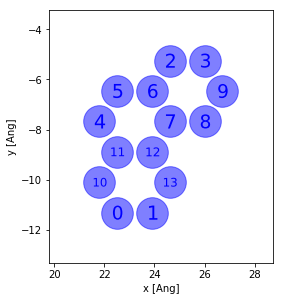

In [5]:
def viewV(V):
    """ Visualize the vertices (nodes) """
    fig, axs = plt.subplots(figsize=(4, 10))
    for i in range(len(V)):
        axs.scatter(V[i,0],V[i,1], s=200, c='b', marker=r"$ {} $".format(str(i)), edgecolors='none')
        axs.scatter(V[i,0],V[i,1], s=1000, c='b', alpha=.5)
    axs.set_xlim(min(V[:,0])-2., max(V[:,0])+2.)
    axs.set_ylim(min(V[:,1])-2., max(V[:,1])+2.)
    axs.set_xlabel('x [Ang]')
    axs.set_ylabel('y [Ang]')
    axs.set_aspect('equal')
    
viewV(V)

In [6]:
# connect first neighbours vetices
def closeV(iv, V, rad):
    """ Returns an array off 1st neighbours indexes """
    idx = np.empty(shape=[0], dtype=np.int32)
    for i in range(iv):
        if np.linalg.norm(V[i]-V[iv]) < rad:
            idx = np.append(idx, [[i]])
    for i in range(iv+1,len(V)):
        if np.linalg.norm(V[i]-V[iv]) < rad:
            idx = np.append(idx, [[i]])
    return idx

def printM(M):
    """ Print out the matrix """
    print(' ', end='')
    for i in range(len(M)):
        print('%2d'%i, end='')
    print('')
    print(M)

def adjacencyG(V):
    """
    Returns the adjacency matrix (which indicates if there
    is an edge, 1, or not, 0, between two vertex) from the
    first neighbours analylis from the vertices in V
    """
    nV = len(V)
    G = np.zeros(shape=[nV, nV], dtype=np.uint8)
    for i in range(nV):
        # list nearest neighbours
        idx = closeV(i, V, 1.43)
        # connect nearest neighbours
        G[i, idx] = 1
    return G

def adjacencySelfIntG(V):
    """
    Returns the adjacency matrix (which indicates if there
    is an edge, 1, or not, 0, between two vertex) from the
    first neighbours analylis from the vertices in V and
    include "self-interaction" diagonal term (on elements
    with only two neighbours)
    """
    nV = len(V)
    G = np.zeros(shape=[nV, nV], dtype=np.uint8)
    for i in range(nV):
        # list nearest neighbours
        idx = closeV(i, V, 1.43)
        # connect nearest neighbours
        G[i, idx] = 1
        # put 1 in the diagonal when necessary
        G[i, i] = 3-len(idx)
    return G

def degreeV(V):
    """
    Returns an array with the vertices
    degree (2 or 3 in our case)
    """
    nV = len(V)
    G = adjacencyG(V)
    degV = np.zeros(shape=[nV], dtype=np.uint8)
    for i in range(nV):
        degV[i] = np.sum(G[i])
    return degV

G = adjacencyG(V)
printM(G)

  0 1 2 3 4 5 6 7 8 910111213
[[0 1 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 1 0 0 0 1 0 1]
 [0 1 0 0 0 0 0 0 0 0 0 0 1 0]]


In [7]:
# band-width reduction
def swapV(G, V, i1, i2):
    """ Swap vertices """
    # swap vertices coordinates
    V[[i1,i2],:] = V[[i2,i1],:]
    # swap columns
    G[:,[i1,i2]] = G[:,[i2,i1]]
    # swap rows
    G[[i1,i2],:] = G[[i2,i1],:]

def naiveReduceBandWidth(G, V):
    """ Naive implementation of band reduction algorithm """
    nV = len(V)
    for i in range(nV-3):
        for j in range(nV-1,i+2,-1):
            if G[i,j]:
                idx = i+2
                while G[i,idx]:
                    idx -= 1
                print(idx,j)
                swapV(G, V, idx, j)

def revCMKinsert(G, degV, labell, queue):
    """ Auxilliary function for revCMK algorithm """
    labell = np.append(labell, queue[0])
    # get neighbours
    ngbr = np.where(G[queue[0],:] == 1)[0]
    # order with increasing degree
    ngbrdeg = np.take(degV, ngbr)
    sortidx = np.unravel_index(np.argsort(ngbrdeg), ngbrdeg.shape)
    ngbr = ngbr[sortidx]
    # remove those already in labell
    mask = np.in1d(ngbr, labell, invert=True)
    ngbr = ngbr[mask]
    # insert neighbours in the queue
    queue = np.append(queue, ngbr)
    
    return labell, queue
                
def revCMK(G, V):
    """
    Reverse Cuthill-McKee algorithm implementation.
    Returns an array with the labell order.
    """
    nV = len(V)

    # vertices degrees
    degV = degreeV(V)
    # sorted with increasing degree
    sdegV = np.argsort(degV)

    # result and queue arrays
    labell = np.empty(shape=[0], dtype=np.uint8)
    queue = np.empty(shape=[0], dtype=np.uint8)
    while len(labell) < nV:
        # remove elements already in labell
        mask = np.in1d(sdegV, labell, invert=True)
        sdegV = sdegV[mask]
        queue = np.append(queue, sdegV[0])
        labell, queue = revCMKinsert(G, degV, labell, queue)
        
        while len(queue) > 0:
            if np.isin(queue[0], labell, invert=True, assume_unique=True):
                labell, queue = revCMKinsert(G, degV, labell, queue)
            # remove the unqueued
            queue = np.delete(queue, 0)

    return labell[::-1]

def reduceBandWidth(G, V):
    labell = revCMK(G, V)
    idx = np.array(range(nV),dtype=np.uint8)
    for i in range(nV):
        if idx[i] != labell[nV-1-i]:
            j = np.where(idx == labell[nV-1-i])[0]
            swapV(G, V, i, int(j))
            idx[i], idx[j] = idx[j], idx[i]
    
G = adjacencyG(V)
printM(G)
reduceBandWidth(G, V)
printM(G)

  0 1 2 3 4 5 6 7 8 910111213
[[0 1 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 1 0 0 0 1 0 1]
 [0 1 0 0 0 0 0 0 0 0 0 0 1 0]]
  0 1 2 3 4 5 6 7 8 910111213
[[0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0]]


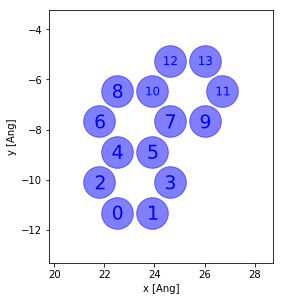

In [8]:
viewV(V)